In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [ ]:
train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 6))
test_idx = ((np.argmax(mnist.test.labels, 1) == 1) | \
            (np.argmax(mnist.test.labels, 1) == 5) | \
            (np.argmax(mnist.test.labels, 1) == 6))

train_imgs   = mnist.train.images[train_idx]
train_labels = mnist.train.labels[train_idx]
test_imgs    = mnist.test.images[test_idx]
test_labels  = mnist.test.labels[test_idx]
n_train      = train_imgs.shape[0]
n_test       = test_imgs.shape[0]

print ("The number of training images : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of testing images : {}, shape : {}".format(n_test, test_imgs.shape))

In [ ]:
# Input
input_h = 28 
input_w = 28 
input_ch = 1 
# (None, 28, 28, 1)

## First convolution layer
k1_h = 3
k1_w = 3
k1_ch = 32
p1_h = 2
p1_w = 2
# (None, 14, 14, 32)

## Second convolution layer
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2
# (None, 7, 7, 64)

k3_h = 7
k3_w = 7
k3_ch = 2
# (None, 1, 1, 2)

dk3_h = 7
dk3_w = 7
dk3_ch = 64
# (None, 7, 7, 64)

## Deconvolution layer
dk2_h = 3
dk2_w = 3
dk2_ch = 32
s2_h = 2
s2_w = 2
# (None, 14, 14, 32)

## Deconvolution layer
dk1_h = 3
dk1_w = 3
dk1_ch = 1
s1_h = 2
s1_w = 2
# (None, 28, 28, 1)

## Output
output_h = 28
output_w = 28
output_ch = 1

In [10]:
weights = {
    'conv1' : tf.Variable(tf.random_normal([k1_h, k1_w, input_ch, k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_h, k2_w, k1_ch, k2_ch], stddev = 0.1)),
    'conv3' : tf.Variable(tf.random_normal([k3_h, k3_w, k2_ch,k3_ch], stddev = 0.1)),
    'deconv3' : tf.Variable(tf.random_normal([dk3_h, dk3_w, dk3_ch, k3_ch], stddev = 0.1)),
    'deconv2' : tf.Variable(tf.random_normal([dk2_h, dk2_w, dk2_ch, dk3_ch], stddev = 0.1)),
    'deconv1' : tf.Variable(tf.random_normal([dk1_h, dk1_w, dk1_ch, dk2_ch], stddev = 0.1))
}

biases = {
    'conv1' : tf.Variable(tf.random_normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_ch], stddev = 0.1)),
    'conv3' : tf.Variable(tf.random_normal([k3_ch], stddev = 0.1)),
    'deconv3' : tf.Variable(tf.random_normal([dk3_ch], stddev = 0.1)),
    'deconv2' : tf.Variable(tf.random_normal([dk2_ch], stddev = 0.1)),
    'deconv1' : tf.Variable(tf.random_normal([dk1_ch], stddev = 0.1)),
}

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, output_h, output_w, output_ch])

In [11]:
def encoder(x, weights, biases):
    ## First convolution layer
    conv1 = tf.nn.conv2d(x, 
                         weights['conv1'],
                         strides = [1, 1, 1, 1],
                         padding = 'SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1,
                           ksize = [1, p1_h, p1_w, 1],
                           strides = [1, p1_h, p1_w, 1],
                           padding = 'VALID')
    
    ## Second convolution layer
    conv2 = tf.nn.conv2d(maxp1, 
                         weights['conv2'],
                         strides = [1, 1, 1, 1],
                         padding = 'SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2,
                           ksize = [1, p2_h, p2_w, 1],
                           strides = [1, p2_h, p2_w, 1],
                           padding = 'VALID')
    
    conv3 = tf.nn.conv2d(maxp2,
                         weights['conv3'],
                         strides = [1, 1, 1, 1],
                         padding = 'VALID')
    conv3 = tf.add(conv3, biases['conv3'])
        
    return conv3

In [12]:
def decoder(latent, weights, biases):    
    deconv3 = tf.nn.conv2d_transpose(latent, 
                                     weights['deconv3'], 
                                     output_shape = [tf.shape(latent)[0], 7, 7, 64], 
                                     strides = [1, 1, 1, 1], 
                                     padding = 'VALID')
    deconv3 = tf.nn.relu(tf.add(deconv3, biases['deconv3']))
    
    ## First deconvolution layer
    deconv2 = tf.nn.conv2d_transpose(deconv3, 
                                     weights['deconv2'], 
                                     output_shape = [tf.shape(deconv3)[0], 14, 14, 32], 
                                     strides = [1, s2_h, s2_w, 1], 
                                     padding = 'SAME')
    deconv2 = tf.nn.relu(tf.add(deconv2, biases['deconv2']))
    
    ## Second deconvolution layer    
    deconv1 = tf.nn.conv2d_transpose(deconv2, 
                                     weights['deconv1'], 
                                     output_shape = [tf.shape(deconv2)[0], 28, 28, 1], 
                                     strides = [1, s1_h, s1_w, 1], 
                                     padding = 'SAME')
    deconv1 = tf.add(deconv1, biases['deconv1'])

    return deconv1

In [13]:
LR = 0.0001

latent = encoder(x, weights, biases)
reconst = decoder(latent, weights, biases)
loss = tf.square(tf.subtract(x, reconst))
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

In [14]:
def train_batch_maker(batch_size):
    random_idx = np.random.randint(n_train, size = batch_size)
    return train_imgs[random_idx], train_labels[random_idx]

In [15]:
def test_batch_maker(batch_size):
    random_idx = np.random.randint(n_test, size = batch_size)
    return test_imgs[random_idx], test_labels[random_idx]

In [16]:
n_batch = 50
n_iter = 5000
n_prt = 250

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

loss_record_train = []
loss_record_test = []
for epoch in range(n_iter):
    train_x, _ = train_batch_maker(n_batch)
    train_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
    sess.run(optm, feed_dict = {x: train_x})    

    if epoch % n_prt == 0:        
        test_x, _ = test_batch_maker(n_batch)
        test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
        c1 = sess.run(loss, feed_dict = {x: train_x})
        c2 = sess.run(loss, feed_dict = {x: test_x})
        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c1))

Iter : 0
Cost : 0.11375708878040314
Iter : 250
Cost : 0.055653251707553864
Iter : 500
Cost : 0.050706807523965836
Iter : 750
Cost : 0.042031485587358475
Iter : 1000
Cost : 0.0431058369576931
Iter : 1250
Cost : 0.03654387593269348
Iter : 1500
Cost : 0.038231298327445984
Iter : 1750
Cost : 0.039299603551626205
Iter : 2000
Cost : 0.04520279914140701
Iter : 2250
Cost : 0.04089757800102234
Iter : 2500
Cost : 0.03797665238380432
Iter : 2750
Cost : 0.03680555894970894
Iter : 3000
Cost : 0.0334743969142437
Iter : 3250
Cost : 0.04065917804837227
Iter : 3500
Cost : 0.03557300195097923
Iter : 3750
Cost : 0.03626122325658798
Iter : 4000
Cost : 0.03710406273603439
Iter : 4250
Cost : 0.03331471234560013
Iter : 4500
Cost : 0.03613777086138725
Iter : 4750
Cost : 0.03608638793230057


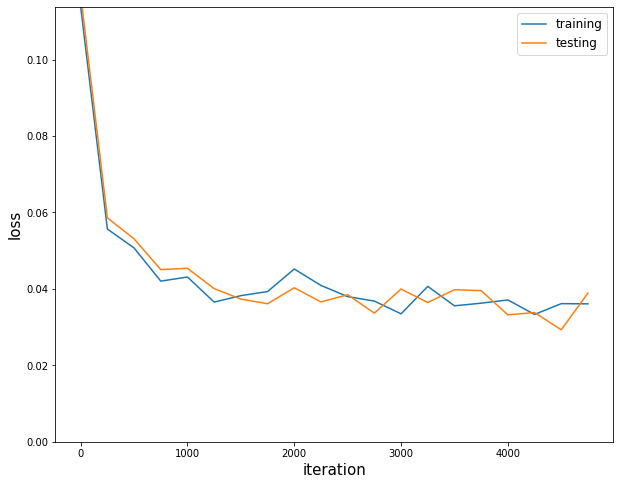

In [17]:
plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, label = 'training')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, label = 'testing')
plt.xlabel('iteration', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

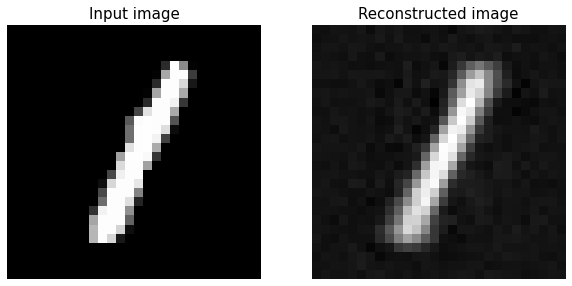

In [18]:
test_x, _ = test_batch_maker(1)
test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
x_reconst = sess.run(reconst, feed_dict = {x: test_x})

plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(test_x.reshape(28,28), 'gray')
plt.title('Input image', fontsize = 15)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x_reconst.reshape(28,28), 'gray')
plt.title('Reconstructed image', fontsize = 15)
plt.axis('off')
plt.show()

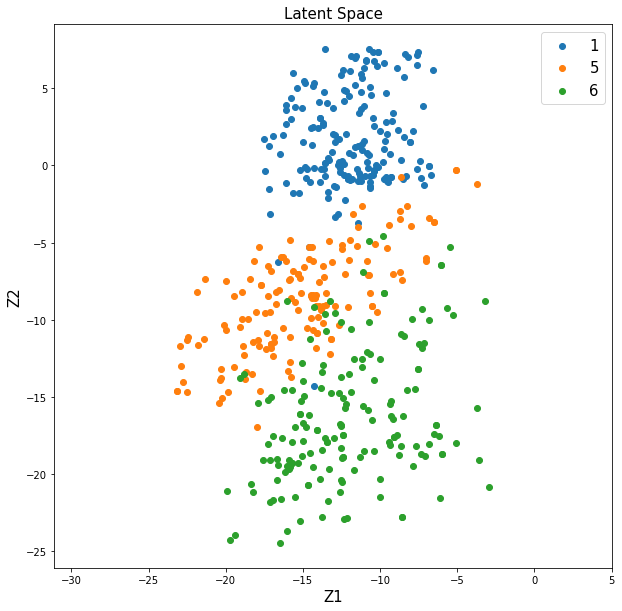

In [19]:
test_x, test_y = test_batch_maker(500)
test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
test_y = np.argmax(test_y, axis = 1)
test_latent = sess.run(latent, feed_dict = {x: test_x})

plt.figure(figsize=(10,10))
plt.scatter(test_latent[test_y == 1,:,:,0], test_latent[test_y == 1,:,:,1], label = '1')
plt.scatter(test_latent[test_y == 5,:,:,0], test_latent[test_y == 5,:,:,1], label = '5')
plt.scatter(test_latent[test_y == 6,:,:,0], test_latent[test_y == 6,:,:,1], label = '6')
plt.title('Latent Space', fontsize=15)
plt.xlabel('Z1', fontsize=15)
plt.ylabel('Z2', fontsize=15)
plt.legend(fontsize = 15)
plt.axis('equal')
plt.show()

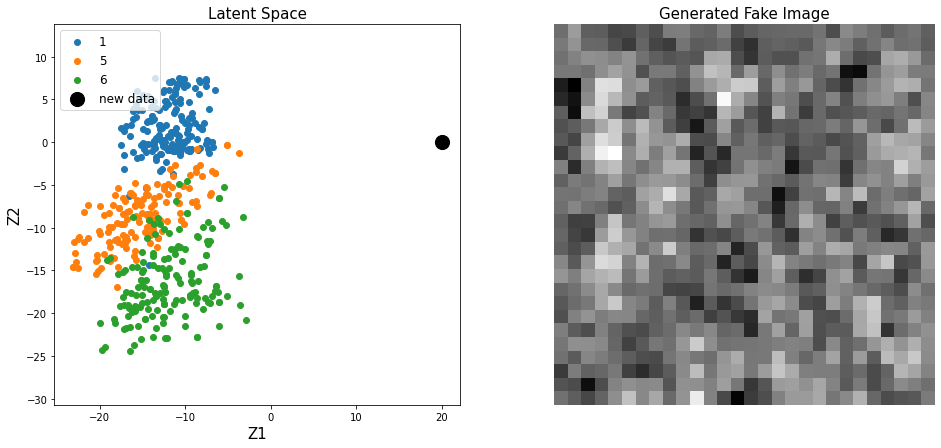

In [20]:
new_data = np.array([[20, 0]]).reshape(-1, 1, 1, k3_ch)

latent_input = tf.placeholder(tf.float32, [None, 1, 1, k3_ch])
reconst = decoder(latent_input, weights, biases)
fake_image = sess.run(reconst, feed_dict = {latent_input: new_data})

plt.figure(figsize = (16,7))
plt.subplot(1,2,1)
plt.scatter(test_latent[test_y == 1,:,:,0], test_latent[test_y == 1,:,:,1], label = '1')
plt.scatter(test_latent[test_y == 5,:,:,0], test_latent[test_y == 5,:,:,1], label = '5')
plt.scatter(test_latent[test_y == 6,:,:,0], test_latent[test_y == 6,:,:,1], label = '6')
plt.scatter(new_data[:,:,:,0], new_data[:,:,:,1], c = 'k', marker = 'o', s = 200, label = 'new data')
plt.title('Latent Space', fontsize = 15)
plt.xlabel('Z1', fontsize = 15)
plt.ylabel('Z2', fontsize = 15)
plt.legend(loc = 2, fontsize = 12)
plt.axis('equal')
plt.subplot(1,2,2)
plt.imshow(fake_image.reshape(28,28), 'gray')
plt.title('Generated Fake Image', fontsize = 15)
plt.axis('off')
plt.show()

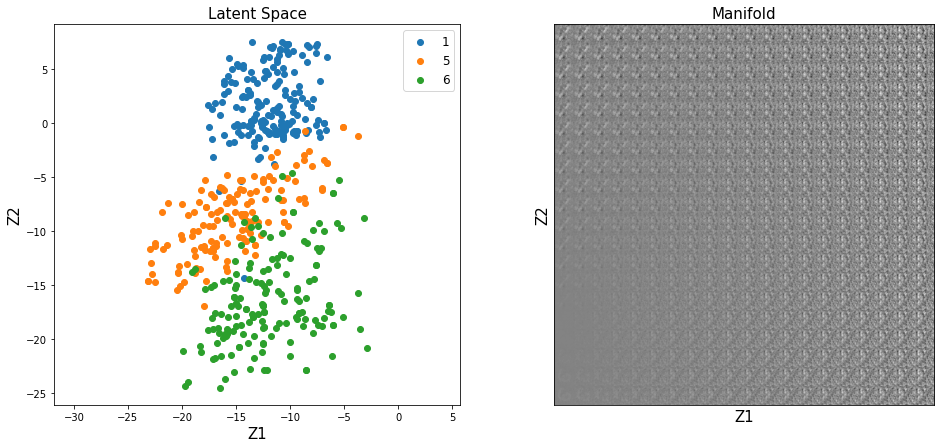

In [21]:
# Initialize canvas
nx = 20
ny = 20
x_values = np.linspace(0, 30, nx)
y_values = np.linspace(-5, 20, ny)
canvas = np.empty((28*ny, 28*nx))

# Define placeholder
latent_input = tf.placeholder(tf.float32, [None, 1, 1, k3_ch])
reconst = decoder(latent_input, weights, biases)

for i, yi in enumerate(y_values):
        for j, xi in enumerate(x_values):
            latent_ = np.array([[xi, yi]]).reshape(-1, 1, 1, k3_ch)
            reconst_ = sess.run(reconst, feed_dict = {latent_input: latent_})
            canvas[(nx-i-1)*28:(nx-i)*28,j*28:(j+1)*28] = reconst_.reshape(28, 28)

plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.scatter(test_latent[test_y == 1,:,:,0], test_latent[test_y == 1,:,:,1], label = '1')
plt.scatter(test_latent[test_y == 5,:,:,0], test_latent[test_y == 5,:,:,1], label = '5')
plt.scatter(test_latent[test_y == 6,:,:,0], test_latent[test_y == 6,:,:,1], label = '6')
plt.title('Latent Space', fontsize = 15)
plt.xlabel('Z1', fontsize = 15)
plt.ylabel('Z2', fontsize = 15)
plt.legend(fontsize = 12)
plt.axis('equal')
plt.subplot(1,2,2)
plt.imshow(canvas, 'gray')
plt.title('Manifold', fontsize = 15)
plt.xlabel('Z1', fontsize = 15)
plt.ylabel('Z2', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.show()

In [22]:
# Input
input_h = 28 
input_w = 28 
input_ch = 1 

## Output
output_h = 28
output_w = 28
output_ch = 1

In [23]:
x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, output_h, output_w, output_ch])

In [24]:
def encoder(x):        
    ## First convolution layer
    conv1 = tf.layers.conv2d(inputs = x, 
                             filters = 32, 
                             kernel_size = [3, 3], 
                             strides = [1, 1],
                             padding = "SAME", 
                             activation = tf.nn.relu)
    maxp1 = tf.layers.max_pooling2d(inputs = conv1, 
                                    pool_size = [2, 2], 
                                    strides = 2)

    ## Second convolution layer
    conv2 = tf.layers.conv2d(inputs = maxp1, 
                             filters = 64, 
                             kernel_size = [3, 3], 
                             padding = "SAME", 
                             activation = tf.nn.relu)
    maxp2 = tf.layers.max_pooling2d(inputs = conv2, 
                                    pool_size = [2, 2], 
                                    strides = 2)

    conv3 = tf.layers.conv2d(inputs = maxp2, 
                             filters = 2, 
                             kernel_size = [7, 7], 
                             padding = "VALID")

    return conv3

In [25]:
def decoder(latent):        
    deconv3 = tf.layers.conv2d_transpose(inputs = latent, 
                                         filters = 64, 
                                         kernel_size = [7, 7], 
                                         padding = 'VALID',
                                         activation = tf.nn.relu)

    ## First deconvolution layer
    deconv2 = tf.layers.conv2d_transpose(inputs = deconv3, 
                                         filters = 32, 
                                         kernel_size = [3, 3], 
                                         strides = (2, 2),
                                         padding = 'SAME',
                                         activation = tf.nn.relu)

    ## Second deconvolution layer    
    deconv1 = tf.layers.conv2d_transpose(inputs = deconv2, 
                                         filters = 1, 
                                         kernel_size = [3, 3], 
                                         strides = (2, 2),
                                         padding = 'SAME')

    return deconv1

In [27]:
LR = 0.0001

latent = encoder(x)
reconst = decoder(latent)
loss = tf.square(tf.subtract(x, reconst))
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

In [28]:
def train_batch_maker(batch_size):
    random_idx = np.random.randint(n_train, size = batch_size)
    return train_imgs[random_idx], train_labels[random_idx]

def test_batch_maker(batch_size):
    random_idx = np.random.randint(n_test, size = batch_size)
    return test_imgs[random_idx], test_labels[random_idx]

In [29]:
n_batch = 50
n_iter = 5000
n_prt = 250

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

loss_record_train = []
loss_record_test = []
for epoch in range(n_iter):
    train_x, _ = train_batch_maker(n_batch)
    train_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
    sess.run(optm, feed_dict = {x: train_x})    

    if epoch % n_prt == 0:        
        test_x, _ = test_batch_maker(n_batch)
        test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
        c1 = sess.run(loss, feed_dict = {x: train_x})
        c2 = sess.run(loss, feed_dict = {x: test_x})
        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c1))

Iter : 0
Cost : 0.1010640412569046
Iter : 250
Cost : 0.05450136587023735
Iter : 500
Cost : 0.03963279351592064
Iter : 750
Cost : 0.03893234208226204
Iter : 1000
Cost : 0.04523136839270592
Iter : 1250
Cost : 0.037442151457071304
Iter : 1500
Cost : 0.03988427296280861
Iter : 1750
Cost : 0.04207591339945793
Iter : 2000
Cost : 0.043132368475198746
Iter : 2250
Cost : 0.03643647953867912
Iter : 2500
Cost : 0.0384991280734539
Iter : 2750
Cost : 0.03984728083014488
Iter : 3000
Cost : 0.03842926025390625
Iter : 3250
Cost : 0.03481683135032654
Iter : 3500
Cost : 0.038862939924001694
Iter : 3750
Cost : 0.0364004485309124
Iter : 4000
Cost : 0.03740665689110756
Iter : 4250
Cost : 0.03641388565301895
Iter : 4500
Cost : 0.03434697538614273
Iter : 4750
Cost : 0.03266299515962601


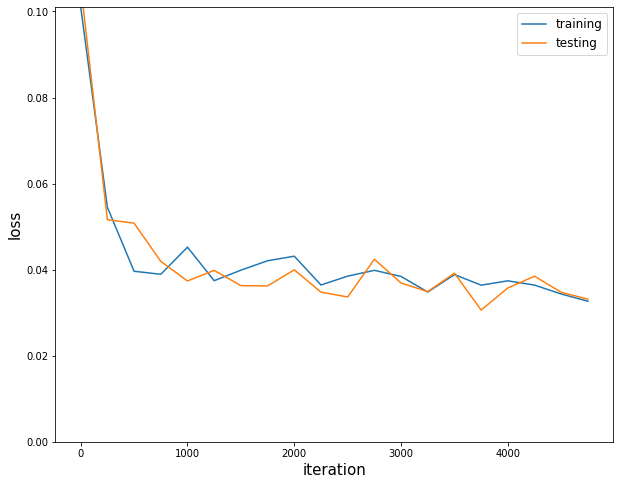

In [30]:
plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, label = 'training')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, label = 'testing')
plt.xlabel('iteration', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

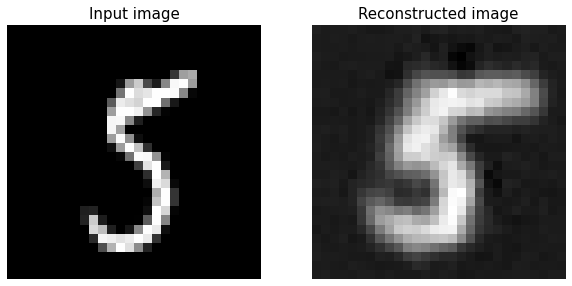

In [31]:
test_x, _ = test_batch_maker(1)
test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
x_reconst = sess.run(reconst, feed_dict = {x: test_x})

plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(test_x.reshape(28,28), 'gray')
plt.title('Input image', fontsize = 15)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x_reconst.reshape(28,28), 'gray')
plt.title('Reconstructed image', fontsize = 15)
plt.axis('off')
plt.show()